# 14 Final Project Customer Segmentation

In [ ]:
# Setup
!pip install -q numpy pandas matplotlib seaborn scikit-learn umap-learn mlxtend

---

## 6. Progetto Finale: Customer Segmentation

In questo progetto applicherai tutte le tecniche apprese per segmentare i clienti di un e-commerce basandosi sul loro comportamento d'acquisto.

### Obiettivi

1. Esplorare e preprocessare i dati
2. Ridurre la dimensionalita con PCA/UMAP
3. Applicare clustering (K-Means)
4. Identificare outlier con Isolation Forest
5. Interpretare e visualizzare i risultati

In [22]:
# PROGETTO FINALE: Customer Segmentation
# Questa sezione e completamente incapsulata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
import umap
import warnings
warnings.filterwarnings('ignore')

# Generazione dataset realistico di clienti e-commerce
np.random.seed(42)
n_customers = 1000

# Feature RFM + comportamentali
data = {
    'customer_id': range(1, n_customers + 1),
    # Recency (giorni dall'ultimo acquisto)
    'recency': np.concatenate([
        np.random.exponential(15, 400),      # Clienti attivi
        np.random.exponential(60, 350),      # Clienti occasionali
        np.random.exponential(150, 250)      # Clienti dormienti
    ]),
    # Frequency (numero acquisti ultimi 12 mesi)
    'frequency': np.concatenate([
        np.random.poisson(15, 400),
        np.random.poisson(5, 350),
        np.random.poisson(1, 250)
    ]),
    # Monetary (spesa totale in euro)
    'monetary': np.concatenate([
        np.random.gamma(5, 200, 400),
        np.random.gamma(3, 100, 350),
        np.random.gamma(2, 50, 250)
    ]),
    # Altre feature
    'avg_basket_size': np.random.gamma(3, 30, n_customers),
    'n_categories': np.random.randint(1, 10, n_customers),
    'return_rate': np.random.beta(2, 10, n_customers),
    'discount_usage': np.random.beta(3, 7, n_customers),
}

df_customers = pd.DataFrame(data)

# Aggiungiamo alcuni outlier (clienti VIP o fraudolenti)
outlier_indices = np.random.choice(n_customers, 20, replace=False)
df_customers.loc[outlier_indices[:10], 'monetary'] *= 10  # VIP
df_customers.loc[outlier_indices[10:], 'return_rate'] = 0.8  # Alto tasso di reso

print("DATASET CLIENTI E-COMMERCE")
print("=" * 50)
print(df_customers.describe().round(2))

DATASET CLIENTI E-COMMERCE
       customer_id  recency  frequency  monetary  avg_basket_size  \
count      1000.00  1000.00    1000.00   1000.00          1000.00   
mean        500.50    61.28       8.00    559.34            90.05   
std         288.82    90.24       6.69    696.70            52.36   
min           1.00     0.08       0.00      6.70             7.11   
25%         250.75     8.67       2.00    139.94            52.19   
50%         500.50    25.71       6.00    352.94            78.91   
75%         750.25    72.61      14.00    858.86           118.69   
max        1000.00   865.21      27.00  11749.69           407.34   

       n_categories  return_rate  discount_usage  
count       1000.00      1000.00         1000.00  
mean           5.00         0.17            0.30  
std            2.55         0.12            0.14  
min            1.00         0.00            0.04  
25%            3.00         0.09            0.19  
50%            5.00         0.15            0

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

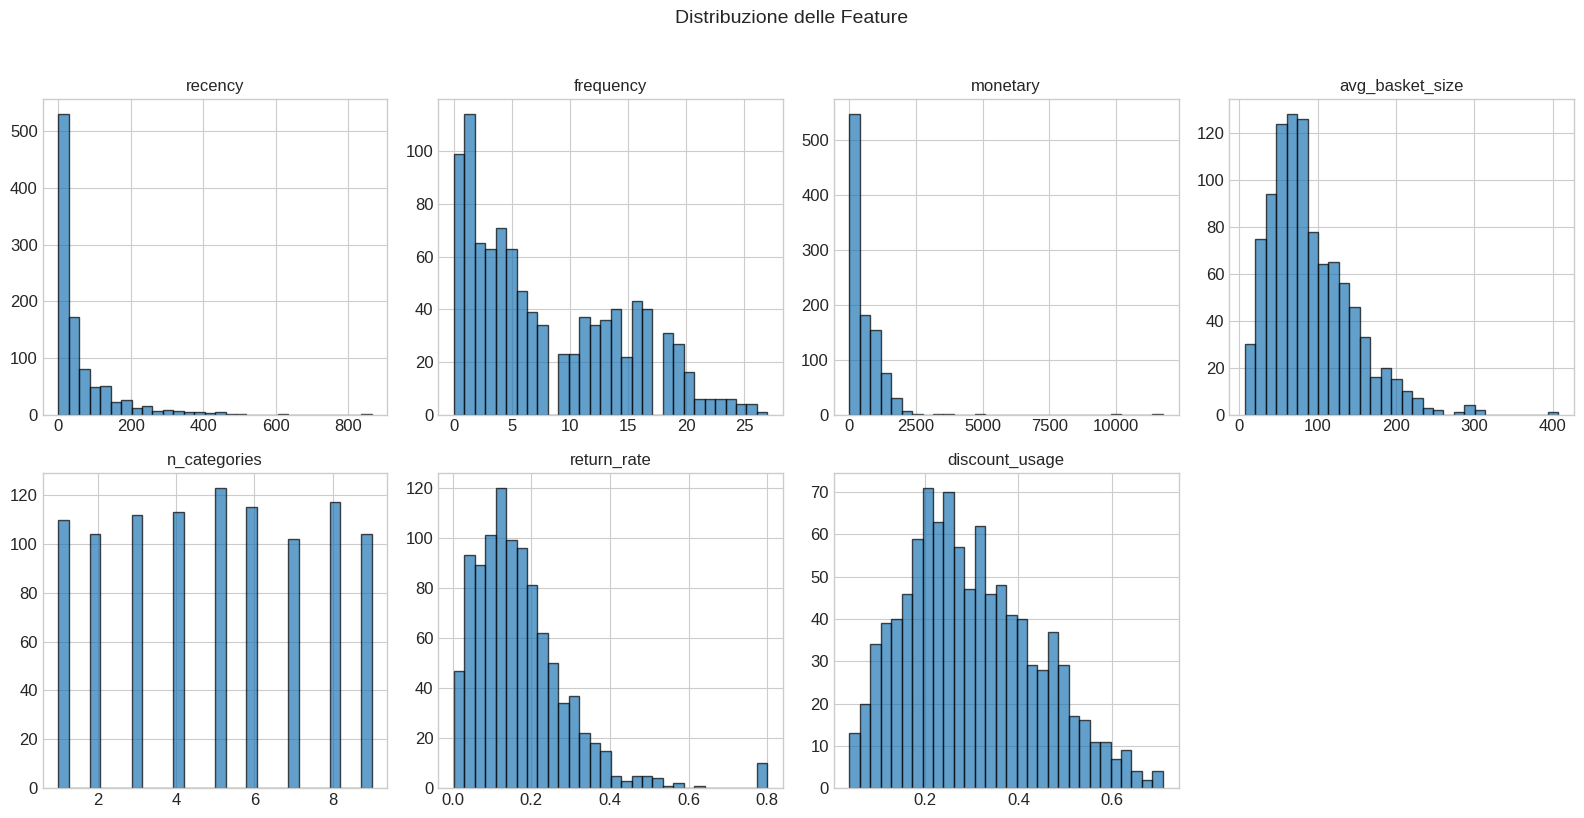

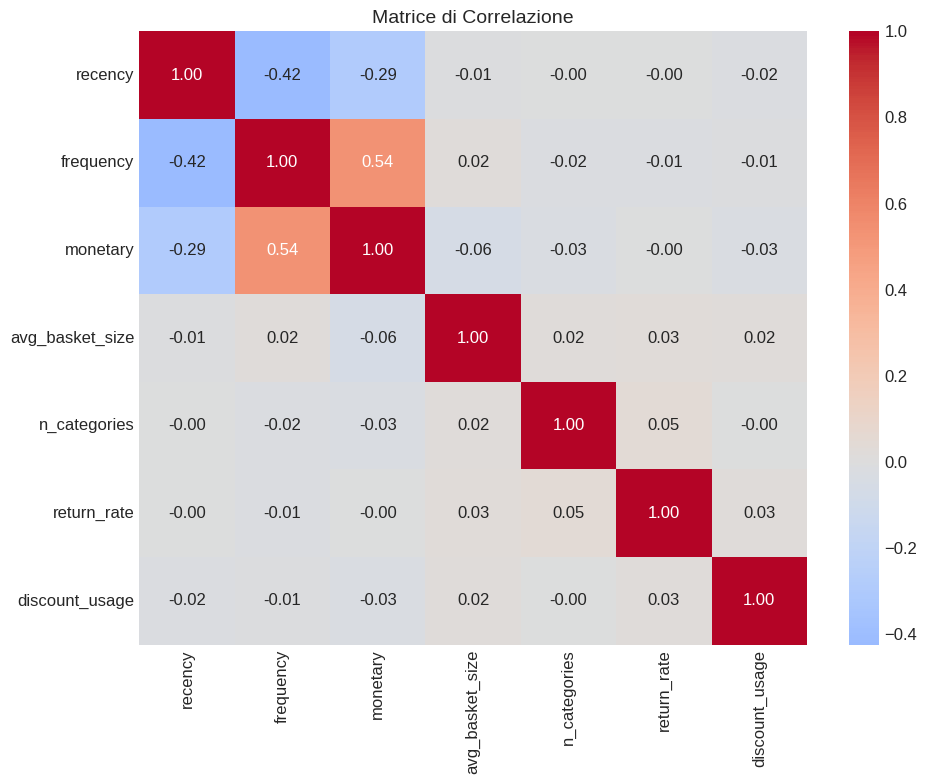

In [23]:
# Step 1: Preprocessing e analisi esplorativa

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Ricreo il dataset (incapsulamento)
np.random.seed(42)
n_customers = 1000

data = {
    'customer_id': range(1, n_customers + 1),
    'recency': np.concatenate([np.random.exponential(15, 400), np.random.exponential(60, 350), np.random.exponential(150, 250)]),
    'frequency': np.concatenate([np.random.poisson(15, 400), np.random.poisson(5, 350), np.random.poisson(1, 250)]),
    'monetary': np.concatenate([np.random.gamma(5, 200, 400), np.random.gamma(3, 100, 350), np.random.gamma(2, 50, 250)]),
    'avg_basket_size': np.random.gamma(3, 30, n_customers),
    'n_categories': np.random.randint(1, 10, n_customers),
    'return_rate': np.random.beta(2, 10, n_customers),
    'discount_usage': np.random.beta(3, 7, n_customers),
}

df_customers = pd.DataFrame(data)
outlier_indices = np.random.choice(n_customers, 20, replace=False)
df_customers.loc[outlier_indices[:10], 'monetary'] *= 10
df_customers.loc[outlier_indices[10:], 'return_rate'] = 0.8

# Selezioniamo le feature per il clustering
features = ['recency', 'frequency', 'monetary', 'avg_basket_size', 'n_categories', 'return_rate', 'discount_usage']
X_customers = df_customers[features].values

# Standardizzazione
scaler_proj = StandardScaler()
X_customers_scaled = scaler_proj.fit_transform(X_customers)

# Visualizzazione distribuzioni
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(features):
    axes[i].hist(df_customers[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')

axes[-1].axis('off')  # Nascondo l'ultimo subplot vuoto

plt.suptitle('Distribuzione delle Feature', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Matrice di correlazione
plt.figure(figsize=(10, 8))
correlation_matrix = df_customers[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matrice di Correlazione', fontsize=14)
plt.tight_layout()
plt.show()

Varianza spiegata (prime 3 PC): 56.2%


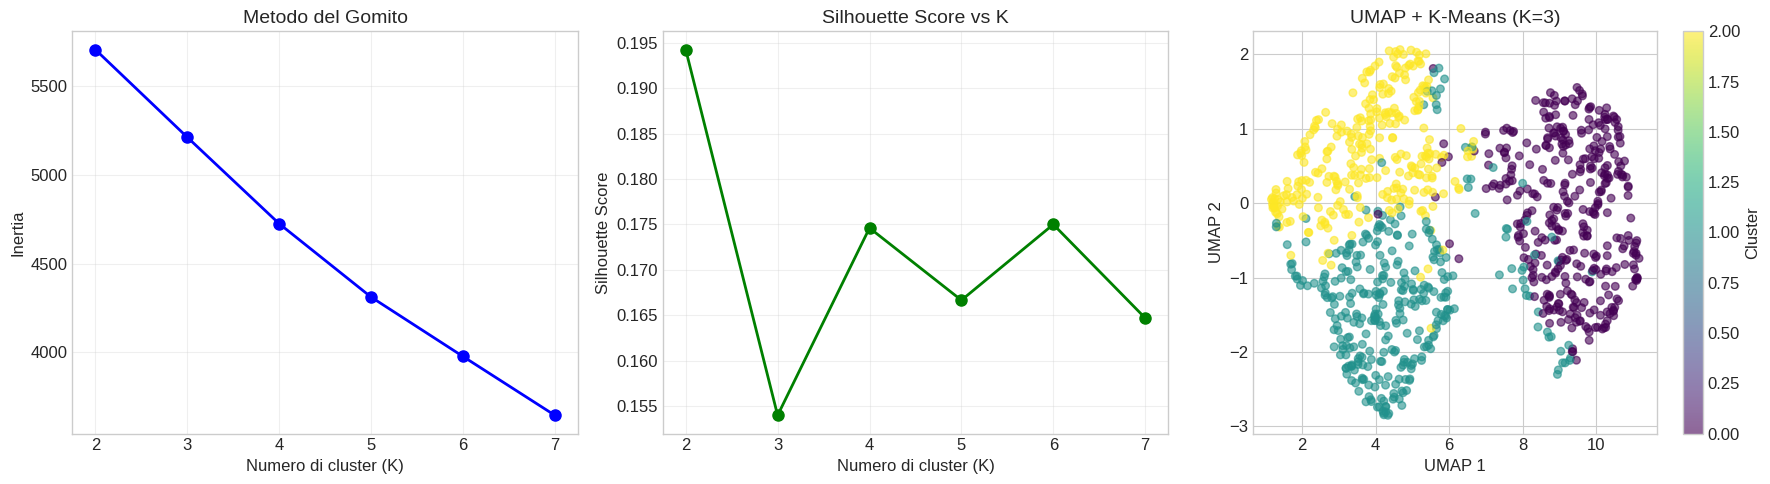

ANALISI SCELTA DI K
  K=2: Silhouette = 0.1942 <--
  K=3: Silhouette = 0.1540
  K=4: Silhouette = 0.1746
  K=5: Silhouette = 0.1666
  K=6: Silhouette = 0.1750
  K=7: Silhouette = 0.1647

K ottimale per Silhouette: 2
Silhouette K=3: 0.1540 (delta da K=2: -0.0403)

Nota: tutti i Silhouette Score sono nel range 0.15-0.19,
che indica una struttura di cluster debole (valori > 0.5
indicano buona separazione). Questo e comune con dati
di alta dimensionalita e feature correlate.

Scelta finale: K=3
Motivazione: la Silhouette preferisce K=2, ma la differenza con K=3 e modesta.
Nell'analisi RFM e-commerce, 3 segmenti (VIP, Occasionali, Dormienti)
rappresentano lo standard di settore. La scelta di K va sempre
bilanciata tra metriche quantitative e conoscenza del dominio.


In [24]:
# Step 2: Riduzione dimensionale + Clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import warnings
warnings.filterwarnings('ignore')

# Ricreo il dataset (incapsulamento)
np.random.seed(42)
n_customers = 1000

data = {
    'customer_id': range(1, n_customers + 1),
    'recency': np.concatenate([
        np.random.exponential(15, 400),
        np.random.exponential(60, 350),
        np.random.exponential(150, 250)
    ]),
    'frequency': np.concatenate([
        np.random.poisson(15, 400),
        np.random.poisson(5, 350),
        np.random.poisson(1, 250)
    ]),
    'monetary': np.concatenate([
        np.random.gamma(5, 200, 400),
        np.random.gamma(3, 100, 350),
        np.random.gamma(2, 50, 250)
    ]),
    'avg_basket_size': (
        np.random.gamma(3, 30, n_customers)
    ),
    'n_categories': (
        np.random.randint(1, 10, n_customers)
    ),
    'return_rate': (
        np.random.beta(2, 10, n_customers)
    ),
    'discount_usage': (
        np.random.beta(3, 7, n_customers)
    ),
}

df_customers = pd.DataFrame(data)
outlier_indices = np.random.choice(
    n_customers, 20, replace=False
)
df_customers.loc[
    outlier_indices[:10], 'monetary'
] *= 10
df_customers.loc[
    outlier_indices[10:], 'return_rate'
] = 0.8

features = [
    'recency', 'frequency', 'monetary',
    'avg_basket_size', 'n_categories',
    'return_rate', 'discount_usage'
]
X_customers = df_customers[features].values
scaler_proj = StandardScaler()
X_customers_scaled = (
    scaler_proj.fit_transform(X_customers)
)

# PCA per varianza spiegata
pca_full = PCA()
pca_full.fit(X_customers_scaled)
print(f"Varianza spiegata (prime 3 PC): {pca_full.explained_variance_ratio_[:3].sum()*100:.1f}%")

# UMAP per visualizzazione
umap_model = umap.UMAP(
    n_components=2, n_neighbors=30,
    min_dist=0.1, random_state=42
)
X_umap = umap_model.fit_transform(X_customers_scaled)

# Trova K ottimale con Elbow + Silhouette
K_range = range(2, 8)
inertias = []
silhouettes = []

for k in K_range:
    kmeans = KMeans(
        n_clusters=k, random_state=42, n_init=10
    )
    labels = kmeans.fit_predict(X_customers_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(
        silhouette_score(X_customers_scaled, labels)
    )

# Visualizzazione
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow plot
axes[0].plot(
    list(K_range), inertias,
    'bo-', linewidth=2, markersize=8
)
axes[0].set_xlabel('Numero di cluster (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Metodo del Gomito', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(
    list(K_range), silhouettes,
    'go-', linewidth=2, markersize=8
)
axes[1].set_xlabel('Numero di cluster (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs K', fontsize=14)
axes[1].grid(True, alpha=0.3)

# UMAP con K=3 (scelta finale)
kmeans_final = KMeans(
    n_clusters=3, random_state=42, n_init=10
)
final_labels = kmeans_final.fit_predict(
    X_customers_scaled
)
scatter = axes[2].scatter(
    X_umap[:, 0], X_umap[:, 1],
    c=final_labels, cmap='viridis',
    alpha=0.6, s=30
)
axes[2].set_title(
    'UMAP + K-Means (K=3)', fontsize=14
)
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
plt.colorbar(scatter, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

# Report sulla scelta di K
k_best_sil = list(K_range)[
    np.argmax(silhouettes)
]
print("=" * 55)
print("ANALISI SCELTA DI K")
print("=" * 55)
for k, sil in zip(K_range, silhouettes):
    marker = " <--" if k == k_best_sil else ""
    print(f"  K={k}: Silhouette = {sil:.4f}{marker}")

print(
    f"\nK ottimale per Silhouette: {k_best_sil}"
)
print(
    f"Silhouette K=3: {silhouettes[1]:.4f} "
    f"(delta da K={k_best_sil}: "
    f"{silhouettes[1] - max(silhouettes):.4f})"
)
sil_min = min(silhouettes)
sil_max = max(silhouettes)
print(
    f"\nNota: tutti i Silhouette Score sono nel range {sil_min:.2f}-{sil_max:.2f},"
    "\nche indica una struttura di cluster debole (valori > 0.5"
    "\nindicano buona separazione). Questo e comune con dati"
    "\ndi alta dimensionalita e feature correlate."
    "\n"
    "\nScelta finale: K=3"
    "\nMotivazione: la Silhouette preferisce K=2, "
    "ma la differenza con K=3 e modesta."
    "\nNell'analisi RFM e-commerce, 3 segmenti "
    "(VIP, Occasionali, Dormienti)"
    "\nrappresentano lo standard di settore. "
    "La scelta di K va sempre"
    "\nbilanciata tra metriche quantitative "
    "e conoscenza del dominio."
)

In [25]:
# Step 3: Analisi dei segmenti + Anomaly Detection

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

# Ricreo il dataset e il clustering (incapsulamento)
np.random.seed(42)
n_customers = 1000

data = {
    'customer_id': range(1, n_customers + 1),
    'recency': np.concatenate([np.random.exponential(15, 400), np.random.exponential(60, 350), np.random.exponential(150, 250)]),
    'frequency': np.concatenate([np.random.poisson(15, 400), np.random.poisson(5, 350), np.random.poisson(1, 250)]),
    'monetary': np.concatenate([np.random.gamma(5, 200, 400), np.random.gamma(3, 100, 350), np.random.gamma(2, 50, 250)]),
    'avg_basket_size': np.random.gamma(3, 30, n_customers),
    'n_categories': np.random.randint(1, 10, n_customers),
    'return_rate': np.random.beta(2, 10, n_customers),
    'discount_usage': np.random.beta(3, 7, n_customers),
}

df_customers = pd.DataFrame(data)
outlier_indices = np.random.choice(n_customers, 20, replace=False)
df_customers.loc[outlier_indices[:10], 'monetary'] *= 10
df_customers.loc[outlier_indices[10:], 'return_rate'] = 0.8

features = ['recency', 'frequency', 'monetary', 'avg_basket_size', 'n_categories', 'return_rate', 'discount_usage']
X_customers = df_customers[features].values
scaler_proj = StandardScaler()
X_customers_scaled = scaler_proj.fit_transform(X_customers)

kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_customers_scaled)
df_customers['cluster'] = cluster_labels

# Profilo dei segmenti
print("=" * 60)
print("PROFILO DEI SEGMENTI CLIENTI")
print("=" * 60)

cluster_profiles = df_customers.groupby('cluster')[features].mean().round(2)
cluster_sizes = df_customers['cluster'].value_counts().sort_index()

for cluster_id in range(3):
    print(f"\nCLUSTER {cluster_id} - {cluster_sizes[cluster_id]} clienti ({100*cluster_sizes[cluster_id]/n_customers:.1f}%)")
    print("-" * 40)
    for feat in features:
        print(f"  {feat}: {cluster_profiles.loc[cluster_id, feat]}")

# Anomaly Detection con Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_customers_scaled)
df_customers['is_anomaly'] = anomaly_labels == -1

print("\n" + "=" * 60)
print("ANOMALY DETECTION")
print("=" * 60)
print(f"Clienti anomali identificati: {sum(df_customers['is_anomaly'])}")
print("\nClienti anomali per cluster:")
print(df_customers.groupby('cluster')['is_anomaly'].sum())

PROFILO DEI SEGMENTI CLIENTI

CLUSTER 0 - 372 clienti (37.2%)
----------------------------------------
  recency: 14.53
  frequency: 15.4
  monetary: 1098.58
  avg_basket_size: 91.1
  n_categories: 5.26
  return_rate: 0.17
  discount_usage: 0.3

CLUSTER 1 - 336 clienti (33.6%)
----------------------------------------
  recency: 56.66
  frequency: 4.26
  monetary: 275.96
  avg_basket_size: 87.1
  n_categories: 2.9
  return_rate: 0.15
  discount_usage: 0.3

CLUSTER 2 - 292 clienti (29.2%)
----------------------------------------
  recency: 126.15
  frequency: 2.86
  monetary: 198.43
  avg_basket_size: 92.09
  n_categories: 7.07
  return_rate: 0.2
  discount_usage: 0.3

ANOMALY DETECTION
Clienti anomali identificati: 20

Clienti anomali per cluster:
cluster
0    9
1    3
2    8
Name: is_anomaly, dtype: int64


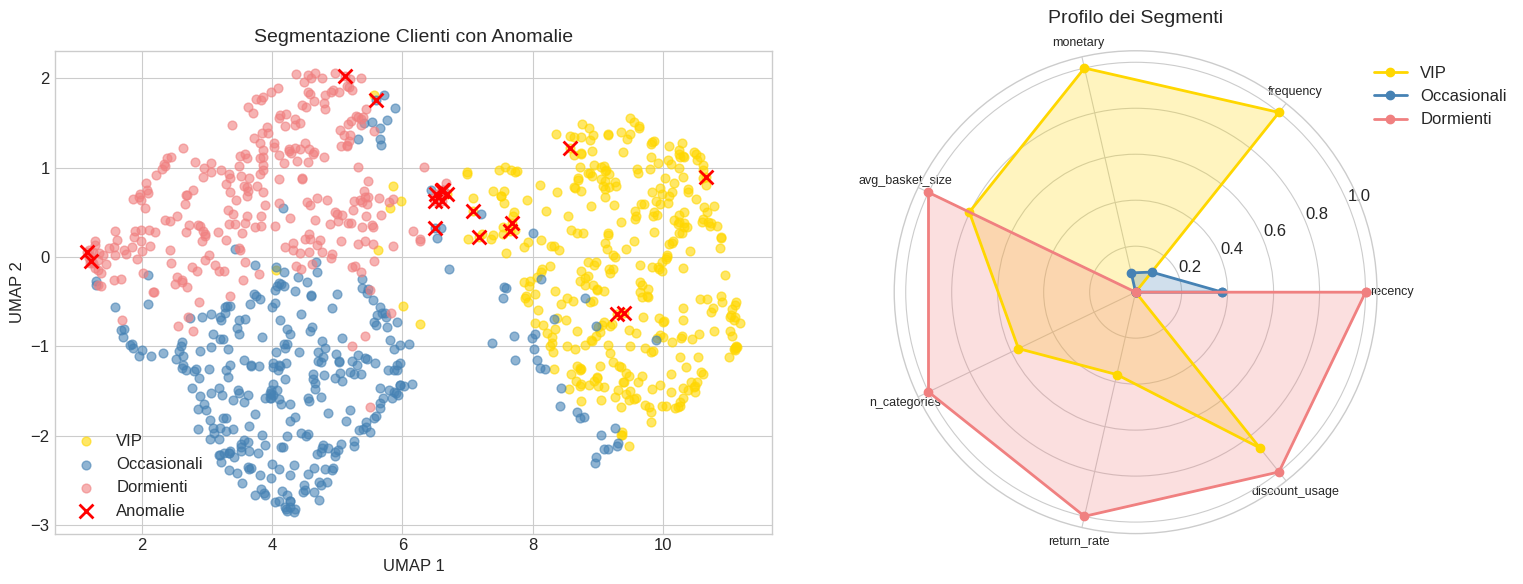


RIEPILOGO SEGMENTAZIONE

Segmento VIP: Alta frequenza, alto valore monetario, bassa recency
Segmento Occasionali: Frequenza media, valore medio
Segmento Dormienti: Bassa frequenza, alta recency, basso valore

Anomalie rilevate: 20 clienti da investigare


In [26]:
# Step 4: Visualizzazione finale e interpretazione

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import umap
import warnings
warnings.filterwarnings('ignore')

# Ricreo tutto (incapsulamento)
np.random.seed(42)
n_customers = 1000

data = {
    'customer_id': range(1, n_customers + 1),
    'recency': np.concatenate([np.random.exponential(15, 400), np.random.exponential(60, 350), np.random.exponential(150, 250)]),
    'frequency': np.concatenate([np.random.poisson(15, 400), np.random.poisson(5, 350), np.random.poisson(1, 250)]),
    'monetary': np.concatenate([np.random.gamma(5, 200, 400), np.random.gamma(3, 100, 350), np.random.gamma(2, 50, 250)]),
    'avg_basket_size': np.random.gamma(3, 30, n_customers),
    'n_categories': np.random.randint(1, 10, n_customers),
    'return_rate': np.random.beta(2, 10, n_customers),
    'discount_usage': np.random.beta(3, 7, n_customers),
}

df_customers = pd.DataFrame(data)
outlier_indices = np.random.choice(n_customers, 20, replace=False)
df_customers.loc[outlier_indices[:10], 'monetary'] *= 10
df_customers.loc[outlier_indices[10:], 'return_rate'] = 0.8

features = ['recency', 'frequency', 'monetary', 'avg_basket_size', 'n_categories', 'return_rate', 'discount_usage']
X_customers = df_customers[features].values
scaler_proj = StandardScaler()
X_customers_scaled = scaler_proj.fit_transform(X_customers)

umap_model = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_customers_scaled)

kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_customers_scaled)

iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_customers_scaled)
anomaly_mask = anomaly_labels == -1

# Visualizzazione finale
fig = plt.figure(figsize=(16, 6))
ax_scatter = fig.add_subplot(121)

# Assegnazione nomi basata sui profili (non hardcoded)
df_customers['cluster'] = cluster_labels
cluster_profiles = df_customers.groupby('cluster')[features].mean()

# Il cluster con monetary piu alto = VIP,
# quello con recency piu alta = Dormienti,
# il rimanente = Occasionali
vip_cluster = cluster_profiles['monetary'].idxmax()
dormant_cluster = cluster_profiles['recency'].idxmax()

# Guard: se VIP e Dormant coincidono, scegli il secondo cluster con recency piu alta come Dormant
if vip_cluster == dormant_cluster:
    dormant_cluster = cluster_profiles['recency'].drop(vip_cluster).idxmax()

occasional_cluster = [c for c in range(3) if c not in (vip_cluster, dormant_cluster)][0]

cluster_names = {
    vip_cluster: 'VIP',
    occasional_cluster: 'Occasionali',
    dormant_cluster: 'Dormienti'
}
color_map = {'VIP': 'gold', 'Occasionali': 'steelblue', 'Dormienti': 'lightcoral'}
colors = [color_map[cluster_names[i]] for i in range(3)]

for i in range(3):
    mask = cluster_labels == i
    ax_scatter.scatter(X_umap[mask, 0], X_umap[mask, 1],
                    c=colors[i], label=cluster_names[i], alpha=0.6, s=40)

ax_scatter.scatter(X_umap[anomaly_mask, 0], X_umap[anomaly_mask, 1],
                c='red', marker='x', s=100, linewidths=2, label='Anomalie')

ax_scatter.set_xlabel('UMAP 1')
ax_scatter.set_ylabel('UMAP 2')
ax_scatter.set_title('Segmentazione Clienti con Anomalie', fontsize=14)
ax_scatter.legend()

# Radar chart dei profili
from math import pi

# Calcolo profili normalizzati
profiles = df_customers.groupby('cluster')[features].mean()
range_vals = profiles.max() - profiles.min()
range_vals = range_vals.replace(0, 1)  # Guard contro divisione per zero
profiles_norm = (profiles - profiles.min()) / range_vals

# Setup radar
categories = features
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax_radar = fig.add_subplot(122, polar=True)

for i in range(3):
    values = profiles_norm.loc[i].values.tolist()
    values += values[:1]
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=cluster_names[i], color=colors[i])
    ax_radar.fill(angles, values, alpha=0.25, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(categories, size=9)
ax_radar.set_title('Profilo dei Segmenti', fontsize=14, pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

# Riepilogo finale
print("\n" + "=" * 60)
print("RIEPILOGO SEGMENTAZIONE")
print("=" * 60)
print("\nSegmento VIP: Alta frequenza, alto valore monetario, bassa recency")
print("Segmento Occasionali: Frequenza media, valore medio")
print("Segmento Dormienti: Bassa frequenza, alta recency, basso valore")
print(f"\nAnomalie rilevate: {sum(anomaly_mask)} clienti da investigare")

---

## 7. Conclusioni e Risorse

### 7.1 Sintesi dei concetti

In questo corso abbiamo esplorato le quattro categorie principali dell'Unsupervised Learning:

| Categoria | Tecniche | Applicazioni |
|-----------|----------|-------------|
| **Clustering** | K-Means, DBSCAN, Hierarchical, GMM | Segmentazione, raggruppamento |
| **Dim. Reduction** | PCA, t-SNE, UMAP | Visualizzazione, preprocessing |
| **Anomaly Detection** | Isolation Forest, LOF | Frodi, manutenzione |
| **Association Rules** | Apriori, FP-Growth | Market basket analysis |

### 7.2 Prossimi passi

Per approfondire l'Unsupervised Learning:

1. **Tecniche avanzate di clustering**: HDBSCAN, Spectral Clustering
2. **Self-Supervised Learning**: contrastive learning, autoencoders
3. **Topic Modeling**: LDA, NMF per testo
4. **Graph-based methods**: community detection, node embedding

### 7.3 Risorse per approfondire

**Libri**
- "Pattern Recognition and Machine Learning" - Christopher Bishop
- "Hands-On Machine Learning" - Aurelien Geron
- "Python Machine Learning" - Sebastian Raschka

**Documentazione**
- [Scikit-learn Unsupervised Learning](https://scikit-learn.org/stable/unsupervised_learning.html)
- [UMAP Documentation](https://umap-learn.readthedocs.io/)
- [mlxtend Documentation](https://rasbt.github.io/mlxtend/)

**Corsi online**
- DataCamp: Unsupervised Learning in Python
- Coursera: Machine Learning Specialization
- Fast.ai: Practical Deep Learning

### 7.4 Progetti suggeriti

1. **Image Clustering**: clusterizza immagini CIFAR-10 con feature estratte da CNN
2. **Customer Churn Analysis**: combina clustering con survival analysis
3. **Document Clustering**: analizza articoli di news con TF-IDF + clustering
4. **Network Intrusion Detection**: applica anomaly detection a dati di rete
5. **Recommendation System**: usa association rules per suggerimenti prodotti

---

## Fine del Corso

Complimenti per aver completato il corso di Unsupervised Learning!

Hai imparato a:
- Applicare algoritmi di clustering per segmentare dati
- Ridurre la dimensionalita per visualizzazione e preprocessing
- Rilevare anomalie in dataset complessi
- Scoprire regole di associazione tra variabili

**Ricorda**: la scelta dell'algoritmo dipende sempre dal problema, dai dati e dagli obiettivi. Non esiste un approccio universale: sperimenta e confronta!